# 모두의 딥러닝
## 19장 세상에 없는 얼굴 GAN, 오토인코더

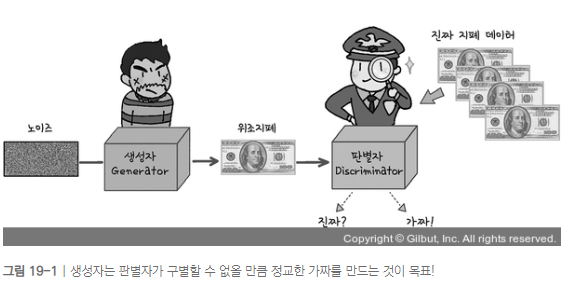

가짜를 만들어 내는 파트를 생성자(Generator) \
진위를 가려내는 파트를 판별자(Discriminator) \

진짜 지폐와 똑같은 위조지폐를 만들기 위해 애쓰는 위조지폐범과 \
이를 가려내기 위해 노력하는 경찰 사이의 경합이 \
결국 더 정교한 위조지폐를 만들어 낸다는 것이 \
적대적경합 (GAN 알고리즘 내부에서 일어나는 일들)

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models,layers

import numpy as np
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"

In [2]:
generator = models.Sequential()

# LeakyReLU()는 0 밑으로 약간의 기울기를 넣어줄 수 있음
# 여기서는 임의로 0.2를 넣어줌
generator.add(layers.Dense(7*7*128, input_dim=100, 
                          activation=layers.LeakyReLU(0.2)))

# BatchNormalization()은 입력값을 0~1사이로 스케일링 해줌
# BatchNormalization()은 자체 파라미터가 있으므로 계산 놉
generator.add(layers.BatchNormalization())

generator.add(layers.Reshape((7, 7, 128)))

# UpSampling2D() 2배로 늘림
generator.add(layers.UpSampling2D())

# padding='same'은 7x7을 5x5로 줄일때 전체 크기는 7x7로 유지시킴
generator.add(layers.Conv2D(64, kernel_size=5, padding='same'))

generator.add(layers.BatchNormalization())

generator.add(layers.Activation(layers.LeakyReLU(0.2)))

generator.add(layers.UpSampling2D())

generator.add(layers.Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [3]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [5]:
# 가짜를 받는 판별자
discriminator = models.Sequential()

# strides=2 커널 윈도를 두칸씩 이동 (디폴트는 1씩 이동)
discriminator.add(layers.Conv2D(64, kernel_size=5, strides=2, 
                         input_shape=(28,28,1), padding="same"))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1, activation='sigmoid'))

# metrics=[]를 선언하지 않는 이유
# 판별자는 오차를 던져주기 위한 용도일뿐이기 때문에 최종결론을 표시해줄필요가없다
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# 기본 디폴트를 학습을 못하게 막음
# 판별자는 자신이 학습되지 않아야함 오직 판별만을 위한것
discriminator.trainable = False

In [6]:
ginput = layers.Input(shape=(100))
dis_output = discriminator(generator(ginput))

# Model(입력, 출력)
gan = models.Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_2 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________
